In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [2]:
# Load Data
trans = pd.read_excel("Transaction.xlsx").dropna()
user = pd.read_excel("User.xlsx").dropna()
city = pd.read_excel("City.xlsx")
country = pd.read_excel("Country.xlsx")
region = pd.read_excel("Region.xlsx")
cont = pd.read_excel("Continent.xlsx")
item = pd.read_excel("Item.xlsx")
upd_item = pd.read_excel("Updated_Item.xlsx")
type_df = pd.read_excel("Type.xlsx")


In [3]:
# Merge items
total_item = pd.concat([item, upd_item]).drop_duplicates('AttractionId', keep='last')


In [4]:
# Cleaning
city['CityName'] = city['CityName'].str.title().str.strip()
trans = trans[trans['Rating'].between(1,5)]

In [5]:
#To join tables
user_full = user.merge(city, on='CityId', how='left')


city_full = city.merge(country, on='CountryId', how='left')\
                .merge(region, on='RegionId', how='left')\
                .merge(cont, on='ContinentId', how='left')


user_full = user.merge(city_full, on='CityId', how='left')


In [6]:
data = trans.merge(user_full, on='UserId').merge(total_item, on='AttractionId').merge(type_df, on='AttractionTypeId')


In [7]:
#To Encode
for col in ['VisitMode', 'Continent', 'Country', 'AttractionType']:
    data[col] = LabelEncoder().fit_transform(data[col])
for col in ['VisitMode', 'Continent', 'Country', 'AttractionType']:
    data[col] = LabelEncoder().fit_transform(data[col])

In [8]:
#Including User Features
data['AvgUserRating'] = data.groupby('UserId')['Rating'].transform('mean')
data['RatingNorm'] = MinMaxScaler().fit_transform(data[['Rating']])

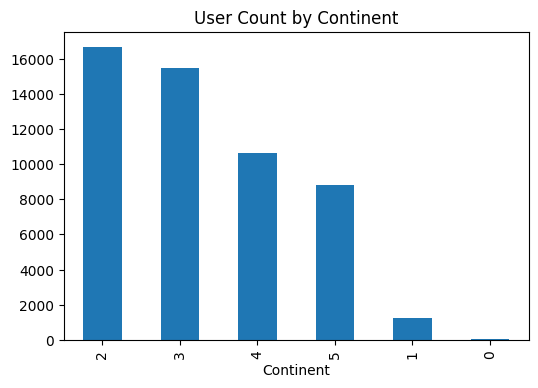

In [9]:
# -------- EDA --------
plt.figure(figsize=(6,4))
data['Continent'].value_counts().plot(kind='bar', title='User Count by Continent')
plt.show()


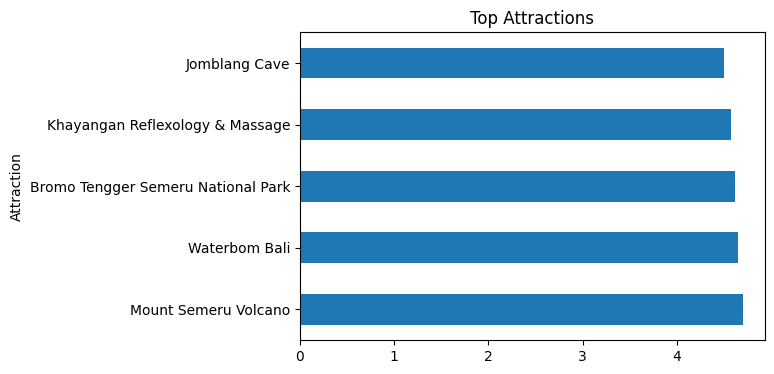

In [31]:

plt.figure(figsize=(6,4))
data.groupby('Attraction')['Rating'].mean().sort_values(ascending=False).head(5).plot(kind='barh', title='Top Attractions')
plt.show()

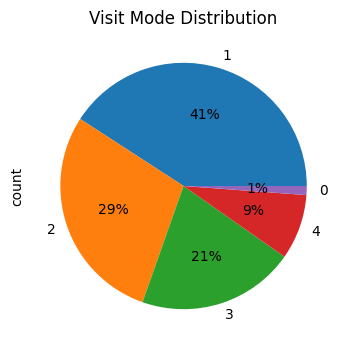

In [32]:
plt.figure(figsize=(6,4))
data['VisitMode'].value_counts().plot(kind='pie', autopct='%1.0f%%', title='Visit Mode Distribution')
plt.show()


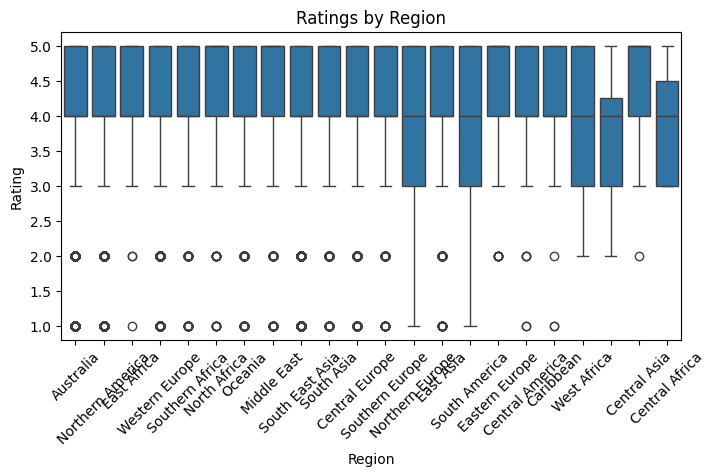

In [33]:
plt.figure(figsize=(8,4))
sns.boxplot(x='Region', y='Rating', data=data)
plt.title('Ratings by Region')
plt.xticks(rotation=45)
plt.show()

In [38]:
# -------- Classification --------
X_cls = data[['Continent', 'Region', 'Country', 'CityName', 'AttractionType']].apply(LabelEncoder().fit_transform)
y_cls = data['VisitMode']
X_train, X_test, y_train, y_test = train_test_split(X_cls, y_cls, test_size=0.2)


In [39]:
clf = RandomForestClassifier().fit(X_train, y_train)
y_pred_cls = clf.predict(X_test)
print(classification_report(y_test, y_pred_cls))


              precision    recall  f1-score   support

           0       0.17      0.06      0.09       121
           1       0.50      0.66      0.57      4380
           2       0.46      0.40      0.43      3061
           3       0.31      0.24      0.27      2171
           4       0.27      0.11      0.15       852

    accuracy                           0.45     10585
   macro avg       0.34      0.29      0.30     10585
weighted avg       0.43      0.45      0.43     10585



In [40]:
joblib.dump(clf, 'visit_mode_model.pkl')


['visit_mode_model.pkl']

In [41]:
# -------- Regression --------
X_reg = data[['Continent', 'Region', 'Country', 'CityName', 'AttractionType', 'AvgUserRating']].apply(LabelEncoder().fit_transform)
y_reg = data['Rating']
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2)


In [42]:
reg = RandomForestRegressor().fit(X_train_r, y_train_r)
y_pred_reg = reg.predict(X_test_r)
print(f"R2: {r2_score(y_test_r, y_pred_reg):.2f}, MSE: {mean_squared_error(y_test_r, y_pred_reg):.2f}")

R2: 0.65, MSE: 0.32


In [43]:
joblib.dump(reg, 'rating_model.pkl')


['rating_model.pkl']